<h3> Run this cell to load necessary packages for CellSeg </h3>

In [3]:
import sys
sys.path.insert(0, '../CellSeg') # clone CellSeg to a folder that is at the same level as this repo

import syotil

import os
from src.cvsegmenter import CVSegmenter
from src.cvstitch import CVMaskStitcher
from src.cvmask import CVMask
from src import cvutils
from src import cvvisualize
from src import fcswrite
import src.walkthrough_utils as wu
from PIL import Image
import skimage
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import defaultdict
import time
from matplotlib.pyplot import imshow, show
from tifffile import imsave

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


<h1> CellSeg Image Segmentation and Marker Quantification Notebook </h1>
<h2> Introduction </h2>
<p>This is a jupyter notebook that implements the segmentation pipeline for CellSeg. 
Follow the instructions in each cell to prepare and segment your images.</p>

<h3>Overview of the CellSeg pipeline</h3>

<p> Below is a walkthrough of the CellSeg pipeline on a multi-stack TIFF image. </p>

<ol type="1">
    <p>
    <li> CellSeg extracts the nuclear channel from image and crops image to accelerate segmentation </li>
    <li> CellSeg segments image </li>
    <li> CellSeg recombines cropped images into final segmented image </li>
    <li> Mask boundaries are grown to capture membrane signal </li>
    <li> Expression of imaged markers is quantified within each cell and exported to .csv and .fcs files </li>    
    </p>
        
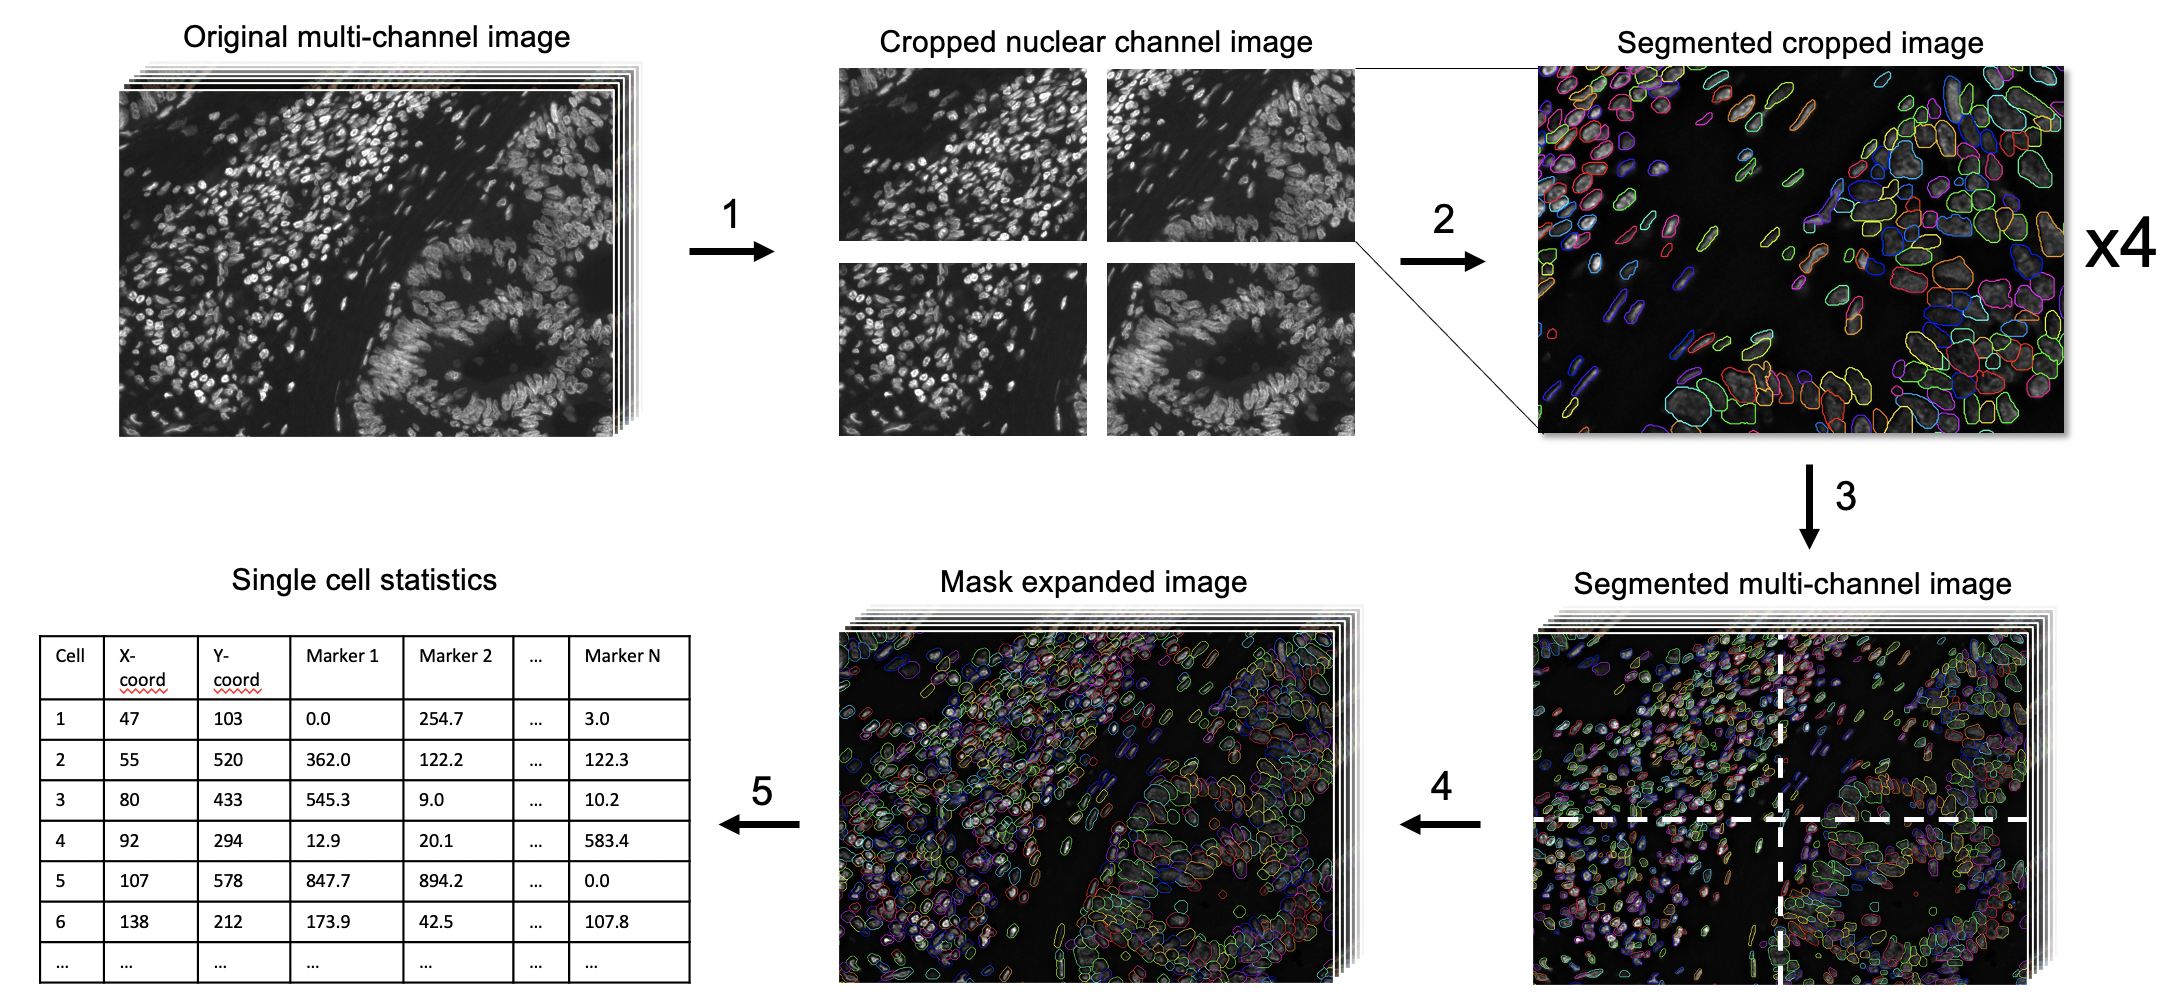

<h3> Input and output folders </h3>
First, specify the file path to the images to segment, then the name of the folder to save output files in. To ensure proper functioning, please enter the full path for the INPUT_PATH.

CellSeg will create the output file directory if it does not exist.

In [1]:
INPUT_PATH = "images\\training\\testimages"; CURR_IM_NAME = 'M872956_JML_Position8_CD3_test_img.png'
#INPUT_PATH = "D:\\DeepLearning\\cellpose_train_immune\\images\\training\\testimages"; CURR_IM_NAME = 'M872956_JML_Position8_CD4_test_img.png'
#INPUT_PATH = "D:\\DeepLearning\\cellpose_train_immune\\cellsegimages"; CURR_IM_NAME = 'M872956_JML_Position8_CD4_train_img.png'
#INPUT_PATH = "D:\\DeepLearning\\cellpose_train_immune\\cellsegtestims"; CURR_IM_NAME = 'HCC_fluo.tif'
OUTPUT_PATH_NAME = "output"

<h3> Filename inclusion and exclusion </h3>

<p> CellSeg will try to segment all images in the input folder with .tif, .png, or .jpg extensions by default. To change this, modify the VALID_IMAGE_EXTENSIONS parameter below. Next, specify any image names or naming end patterns corresponding to images that you wish to exclude from the segmentation with the FILENAME_ENDS_TO_EXCLUDE parameter. After running this cell, CellSeg will report the images in the folder that can be segmented. </p>

<p> Formatting: enter patterns and names in single quotes separated by a comma inside the parentheses </p>
<p> Ex. FILENAME_ENDS_TO_EXCLUDE = ('image1.tif', 'image2.jpg', 'pattern1') </p>

In [4]:
###EDIT THESE PARAMETERS###

FILENAME_ENDS_TO_EXCLUDE = ('montage.tif')

VALID_IMAGE_EXTENSIONS = ('tif', 'jpg', 'png')

###########################


FILENAMES = [f for f in os.listdir(os.path.join(INPUT_PATH, '')) if f.endswith(
            VALID_IMAGE_EXTENSIONS) and not f.startswith('.') and not f.endswith(FILENAME_ENDS_TO_EXCLUDE)]
if len(FILENAMES) < 1:
    raise NameError(
        'No image files found.  Make sure you are pointing to the right directory')
else:
    print("Available images to segment at " + os.path.join(INPUT_PATH, 'bestFocus'))
    print(FILENAMES)

Available images to segment at images\training\testimages\bestFocus
['M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M872956_JML_Position9_CD3_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M926910_CFL_Position7_CD3_test_img.png']


<h3> Specify input data type</h3>

Now, specify if the input data is from a CODEX experiment. For RGB or 2D greyscale images, set IS_CODEX_OUTPUT = False.

If IS_CODEX_OUTPUT = True or if image ends in '.tif', then specify the NUCLEAR_CHANNEL_NAME for the tiff slice to segment on.

In [5]:
###EDIT THESE PARAMETERS###

IS_CODEX_OUTPUT = False

NUCLEAR_CHANNEL_NAME = "a"

###########################



CHANNEL_NAMES = []
ext = FILENAMES[0].split('.')[-1]
if 'tif' in ext:
    CHANNEL_NAMES = pd.read_csv(
        os.path.join(INPUT_PATH, "channelNames.txt"), sep='\t', header=None).values[:, 0]
    if NUCLEAR_CHANNEL_NAME not in CHANNEL_NAMES:
        raise NameError(
            'Nuclear channel name not found. Please double check channelNames.txt file')
    print('Picking channel', NUCLEAR_CHANNEL_NAME, 'from',
        len(CHANNEL_NAMES), 'total to segment on')
    print('Channel names:')
    print(CHANNEL_NAMES)

<h3> Specify image boosting parameters </h3>

Specify if you would like to boost the image, the method, and if auto, the image you would like to use for boosting

Example of fluorescence image of human spleen stained with DAPI (Left), image boosted by factor of 5.0 (Middle), and image boosted by factor of 10.0 (Right).

USE_BOOST (True/False): specify if images should be boosted

BOOST ('auto' or double): specify the boosting method. If double is supplied, then CellSeg will boost all images by that value. 

AUTOBOOST_REFERENCE_IMAGE: name of the reference image to use to autoboost. If an invalid image name is provided, then CellSeg will default to using the first image in the directory to boost.

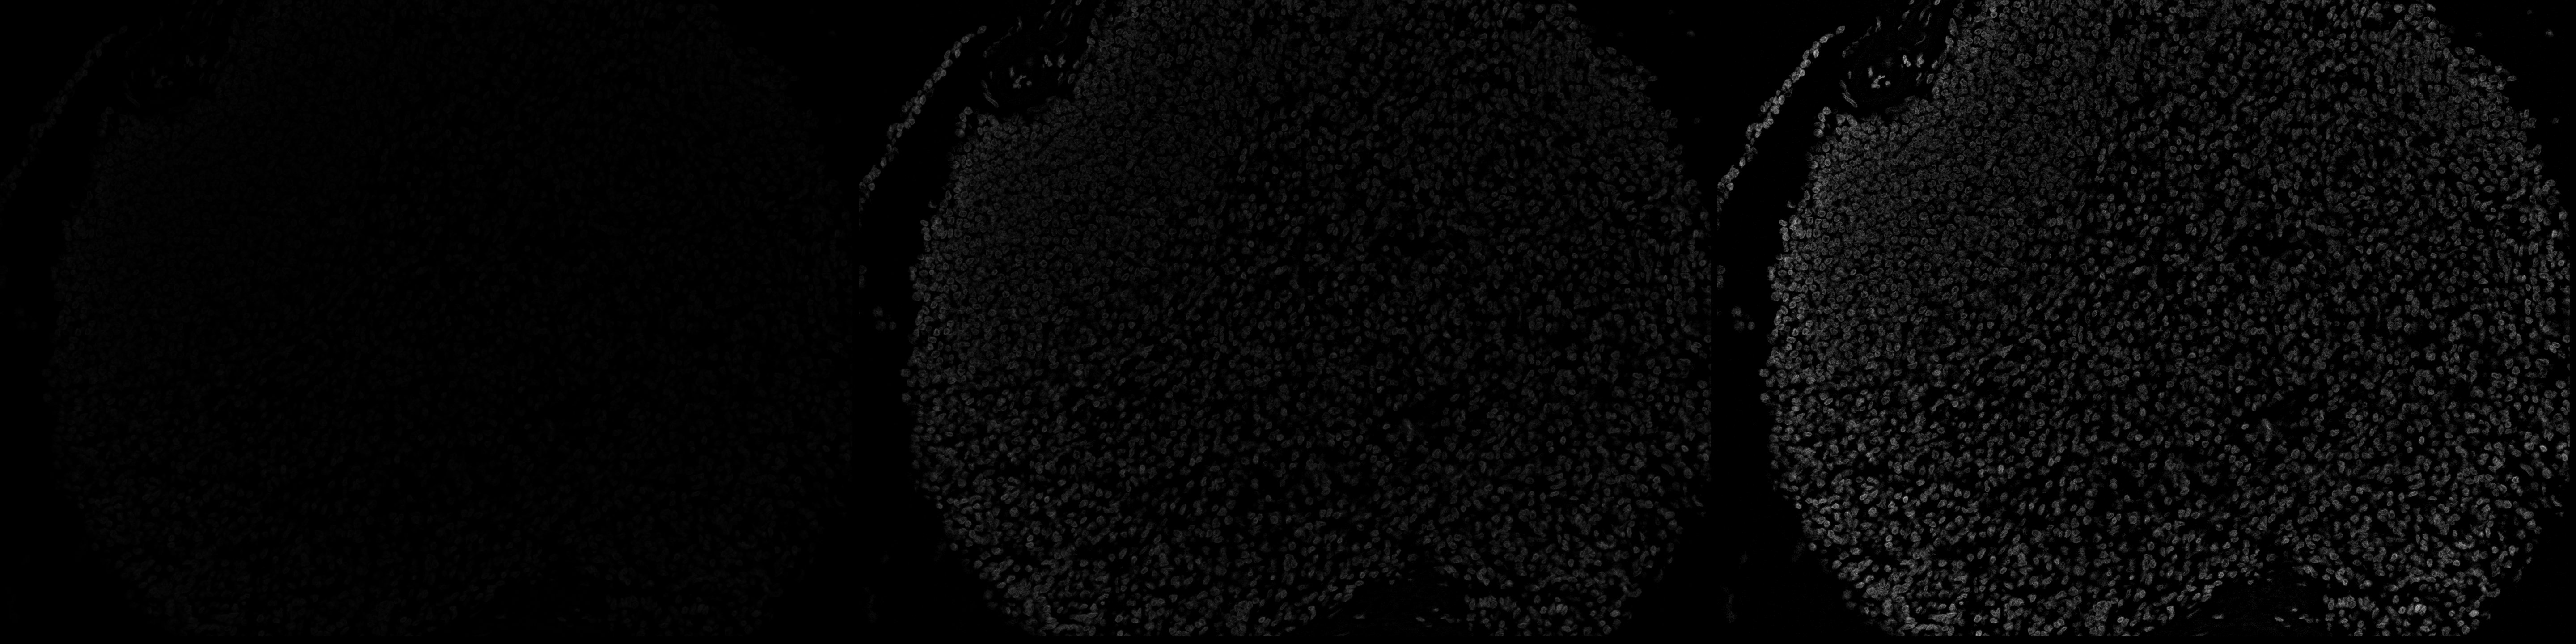

In [10]:
###EDIT THESE PARAMETERS###

USE_BOOST = False

BOOST = 'auto'

AUTOBOOST_REFERENCE_IMAGE = "Insert autoboost reference image here"

###########################


reference_image_path = os.path.join(INPUT_PATH, '', FILENAMES[0])


if AUTOBOOST_REFERENCE_IMAGE in FILENAMES:
    reference_image_path = os.path.join(INPUT_PATH, 'bestFocus', AUTOBOOST_REFERENCE_IMAGE)
else:
    print("Autoboost reference image not found. Using first image in images folder:", reference_image_path, "\n")

N_DIMS, EXT, DTYPE, SHAPE, READ_METHOD = cvutils.meta_from_image(reference_image_path)

print("Working with images of shape:", SHAPE)

if USE_BOOST and BOOST == 'auto':
    BOOST = wu.compute_boost(reference_image_path, READ_METHOD, IS_CODEX_OUTPUT,
                               SHAPE, N_DIMS, NUCLEAR_CHANNEL_NAME, CHANNEL_NAMES)

Autoboost reference image not found. Using first image in images folder: images\training\testimages\M872956_JML_Position10_CD3_test_img.png 

Working with images of shape: (1040, 233, 1)


<h3> Advanced parameters </h3>

Run this cell to load advanced parameters needed for segmentation.

OVERLAP- the amount of pixel overlap between crops if a large image is segmented

THRESHOLD- the minimum area (in pixels) of masks to keep after segmentation

INCREASE_FACTOR- amount to boost image size by for segmentation

In [11]:
OVERLAP = 80
THRESHOLD = 2
INCREASE_FACTOR = 2.5

<h3> Loading image stitching and segmentation models </h3>

Run this cell to load the necessary image stitching object and segmentation model.

In [12]:
###DO NOT EDIT###

root = os.path.join(os.path.abspath("CellSeg_stepbystep.ipynb").replace("CellSeg_stepbystep.ipynb", ""), "../cellseg")

stitcher = CVMaskStitcher(overlap=OVERLAP)
segmenter = CVSegmenter(
        SHAPE,
        os.path.join(root, "src", "modelFiles", "final_weights.h5"),
        OVERLAP,
        INCREASE_FACTOR,
        THRESHOLD
    )
rows, cols = None, None
dataframe_regs = defaultdict(list)
columns = []
path = ''

print("\n", "Names of images to segment")
print(FILENAMES)

#################

Initializing model with weights located at D:\DeepLearning\cellpose_train_immune\../cellseg\src\modelFiles\final_weights.h5
Using autosizing for image shape

 Names of images to segment
['M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M872956_JML_Position9_CD3_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M926910_CFL_Position7_CD3_test_img.png']


In [13]:
vars(segmenter)

{'overlap': 80,
 'shape': (1040, 233, 1),
 'nrows': 2,
 'ncols': 1,
 'model': <src.cvmodel.MaskRCNN at 0x23d9bd749b0>,
 'threshold': 2}

<h3> Select image to segment </h3>
Next, input name of image to segment from list of filenames printed above. 

In [17]:
###EDIT THESE PARAMETERS###


NUCLEAR_CHANNEL_NAME="a"
###########################


path = os.path.join(INPUT_PATH, '', CURR_IM_NAME)
image = np.array(READ_METHOD(path))


if 'tif' in ext:
    if N_DIMS == 4:
        image = np.transpose(image, (2, 3, 0, 1))
    elif N_DIMS == 3:
        image = np.transpose(image, (1, 2, 0))
image = image.reshape(SHAPE)
nuclear_index = None
if 'tif' in ext:
    nuclear_index = cvutils.get_channel_index(NUCLEAR_CHANNEL_NAME, CHANNEL_NAMES)
nuclear_image = cvutils.get_nuclear_image(N_DIMS-1, image, nuclear_index=nuclear_index)
if USE_BOOST:
    nuclear_image = cvutils.boost_image(nuclear_image, BOOST)

print("Boosted Nuclear Image")
#nuclear_image=image[:,:,0]
#nuclear_image = np.expand_dims(nuclear_image, axis=-1)
print(nuclear_image.shape)

#imshow(nuclear_image)
#show()



Boosted Nuclear Image
(1040, 233, 3)


(1040, 233)


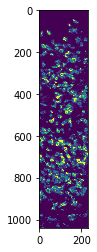

In [18]:
from matplotlib import pyplot as plt
from skimage import data, io
img=io.imread(path)
plt.imshow(img)
print(img.shape)

<h3> Run this to segment images and generate masks </h3>

Segmenting M872956_JML_Position8_CD3_test_img.png on channel a
Dividing image into 2 crops with 2 rows and 1 columns
Segmented crop in 11.466094970703125 seconds.
Segmented crop in 10.147328853607178 seconds.
Stitching together cropped segmented subimages
Removing masks with area less than 8 pixels.
Showing stitched masks


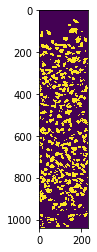

433 cell masks found by segmenter


In [19]:
###DO NOT EDIT###

print("Segmenting " + CURR_IM_NAME + " on channel " + NUCLEAR_CHANNEL_NAME)
masks, rows, cols = segmenter.segment_image(nuclear_image)
#stitched_mask = stitcher.stitch_masks(masks, rows, cols)
print("Stitching together cropped segmented subimages")
stitched_mask = CVMask(stitcher.stitch_masks(masks, rows, cols))
instances = stitched_mask.n_instances()
print(instances, 'cell masks found by segmenter')
if instances == 0:
    print('No cells found in', filename)

#figsize = (SHAPE[1] // 25, SHAPE[0] // 25)

#################

In [20]:
masks[0].shape

(560, 233)

<h3> Mask growth method </h3>

<p> Select whether or not you want to grow segmented masks. If you select GROW_MASKS = True,
please additionally set the number of pixels with GROWTH_PIXELS (integer) to extend each mask by and 
the growth method you would like to use. </p>

GROWTH_METHOD option details:
<ul>
    <li> 'Standard': grows all masks by specified number of pixels. If two masks overlap after growth, then 
    pixels in the overlap region are assigned to the mask with the closest centroid. </li>
    <li> 'Sequential': iterates over the segmented cells, growing the boundary of each cell by 1 pixel until that cell's boundary collides with another cell's boundary. This process continues until all cells' boundaries have been grown by GROWTH_PIXELS pixels or the cells' boundaries have all collided. </li>
</ul>

<p> Left image is 0 growth, middle image is sequential growth by 2 pixels, right image is sequential growth by 4 pixels </p>

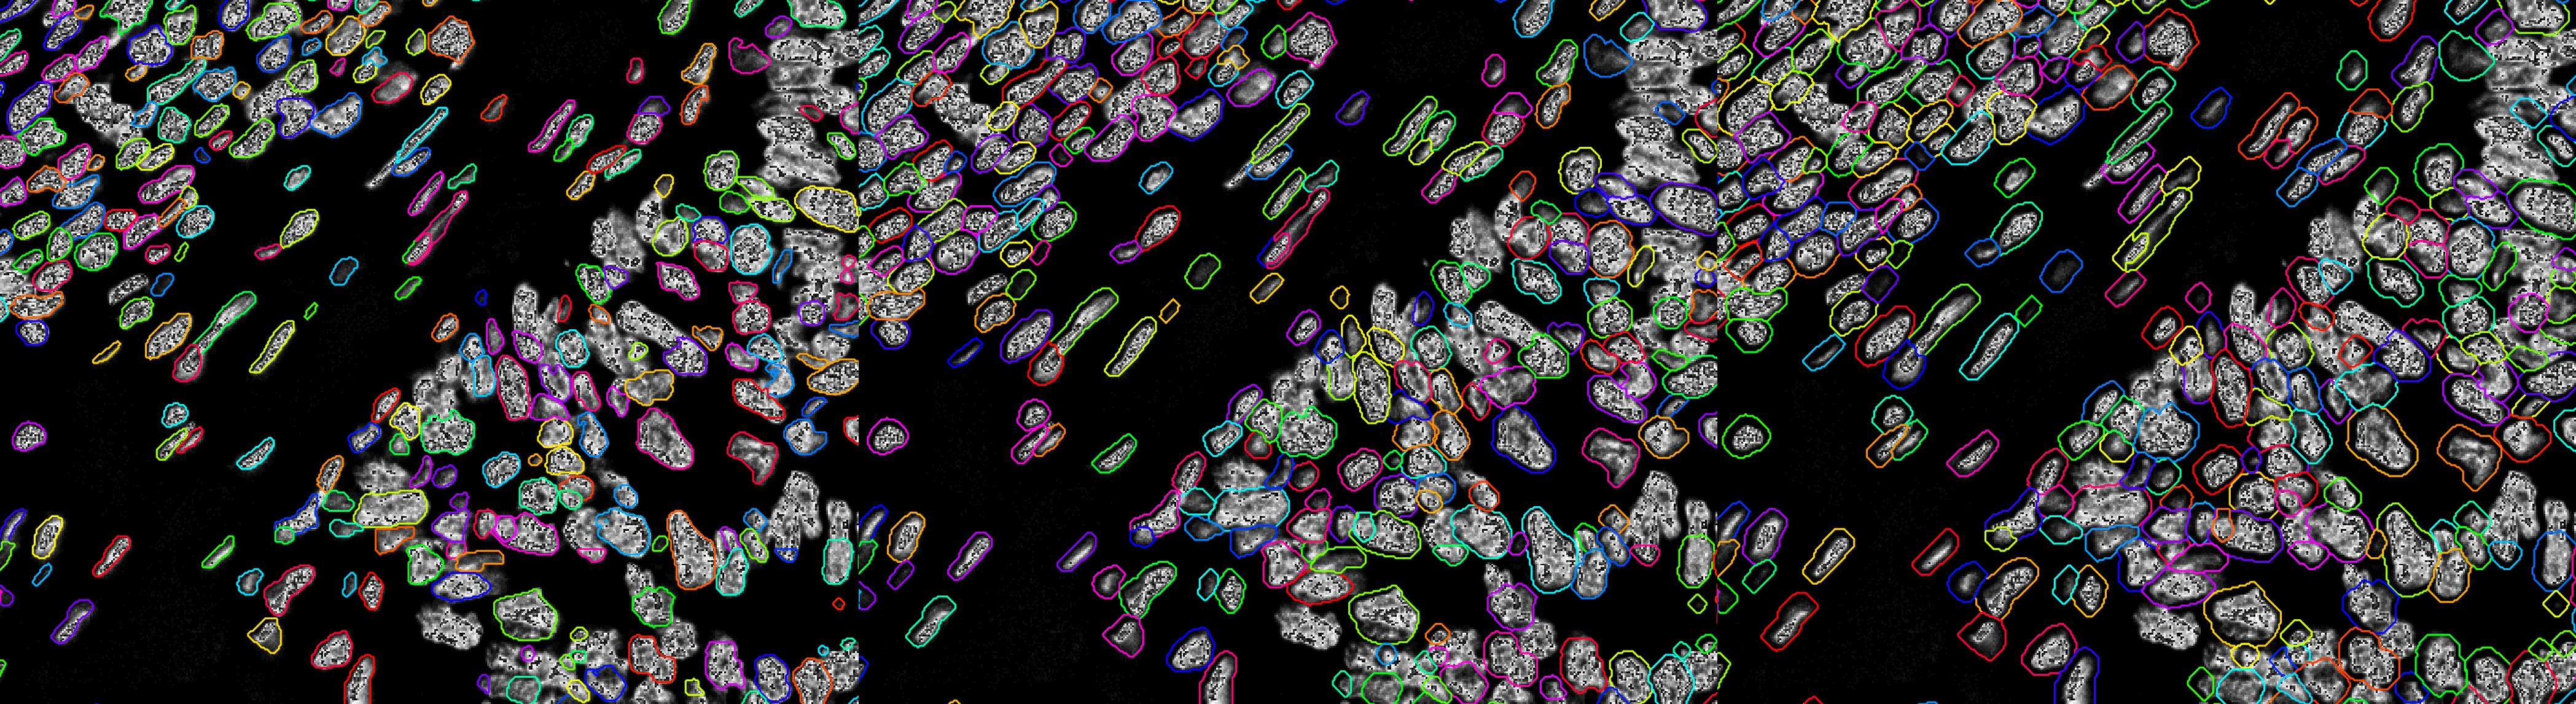

In [21]:
###EDIT THESE PARAMETERS###

GROW_MASKS = False

GROWTH_PIXELS = 0

GROWTH_METHOD = 'Sequential'

###########################



if GROW_MASKS:
    print("Computing centroids and bounding boxes for the masks.")
    stitched_mask.compute_centroids()
    stitched_mask.compute_boundbox()
    print(f"Growing masks by {GROWTH_PIXELS} pixels")
    stitched_mask.grow_masks(GROWTH_PIXELS, GROWTH_METHOD)

<h2> Output method </h2>
<p> The following three cells contain the three possible data outputs from the segmentation. </p>


Output option details:

<ul>
    
<li> VISUAL IMAGE OUTPUT- this option outputs a png image of the tissue with the cell boundaries overlaid on top (Left image in figure). </li>

<li> VISUAL OVERLAY OUTPUT- this option outputs a tif image containing the cell boundaries as ROI regions which can be opened in programs such as ImageJ and used to do computations (Middle image in figure). </li>

<li> STATISTICS- this option outputs a csv file and fcs file each containing information for each identified cell including marker quantification, the (x,y) coordinate of the cell, and the size of the cell (Right image in figure. </li>

</ul>

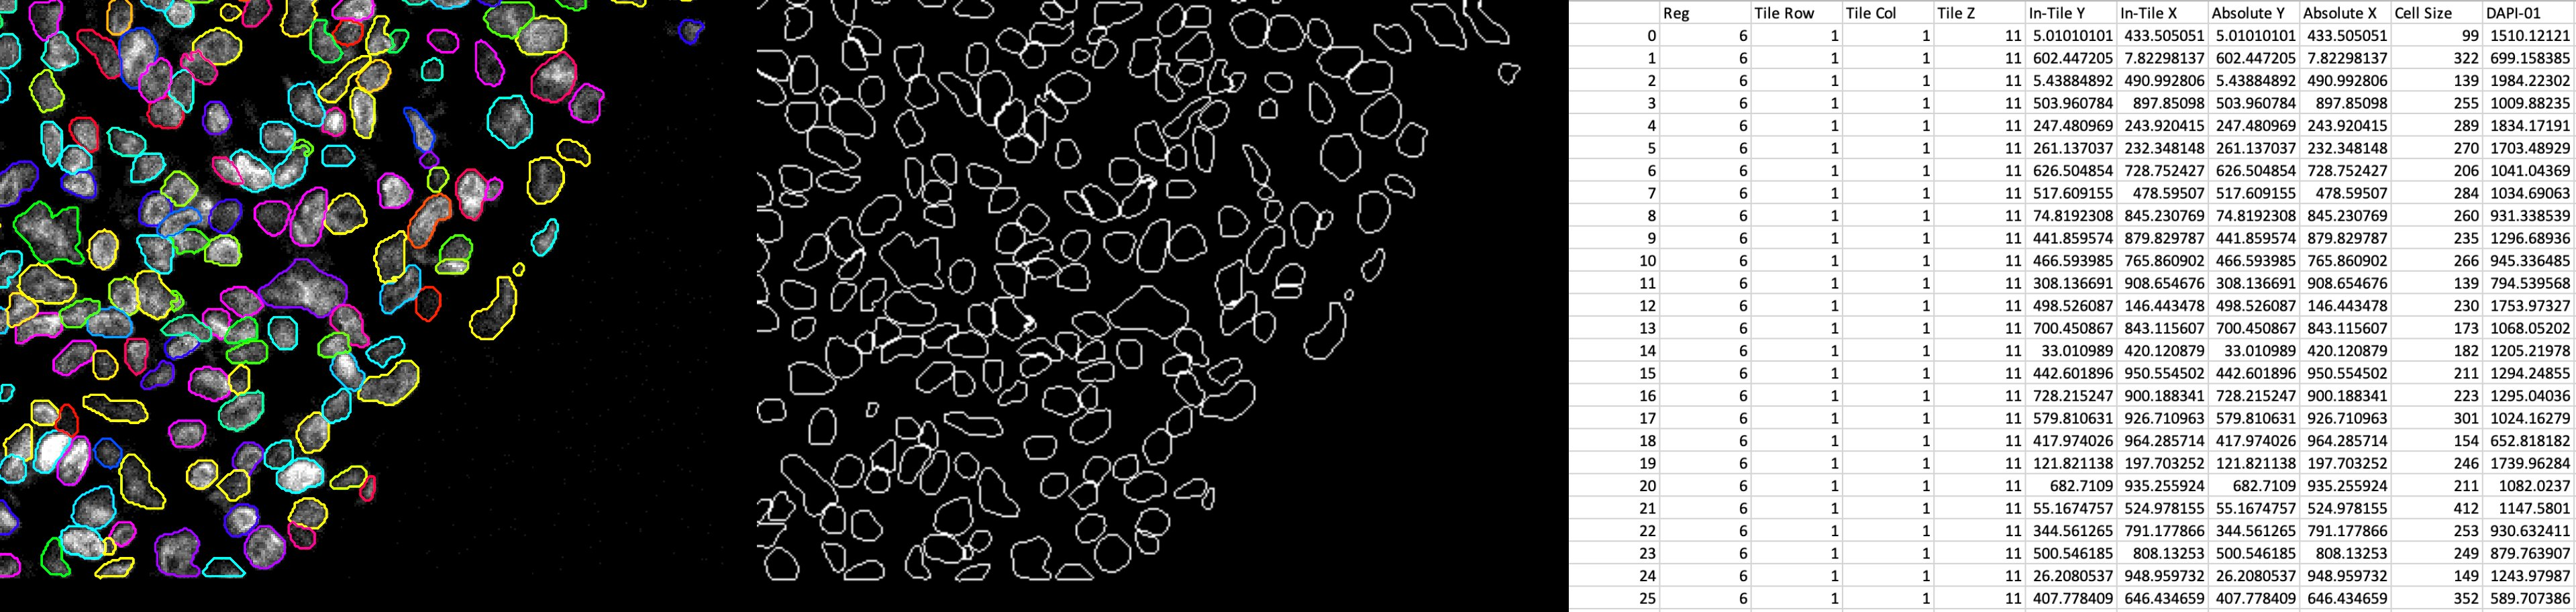

<h3> STATISTICS </h3>

<p> Run this cell to quantify the pixel expression of markers in the channelNames.txt file in a csv or fcs file. </p>

<p> SHOULD_COMPENSATE (True/False): whether to use lateral fluorescent bleed compensation (Goltsev et al Cell 2018) in the quantification </p>

<p> CSV_OR_FCS ('csv'/'fcs'): how to save quantification results </p>

In [22]:
###EDIT THESE PARAMETERS###

SHOULD_COMPENSATE = False

CSV_OR_FCS = 'csv'

###########################

stitched_mask.compute_centroids()
stitched_mask.compute_boundbox()

output_masks = stitched_mask

QUANTIFICATION_OUTPUT_PATH = os.path.join(root, OUTPUT_PATH_NAME, 'quantifications')

if not os.path.isdir(QUANTIFICATION_OUTPUT_PATH):
    os.makedirs(QUANTIFICATION_OUTPUT_PATH)

wu.compute_stats(output_masks, CURR_IM_NAME, image, IS_CODEX_OUTPUT, CHANNEL_NAMES, 
                 SHOULD_COMPENSATE, QUANTIFICATION_OUTPUT_PATH, CSV_OR_FCS, GROWTH_PIXELS)

Calculating statistics: M872956_JML_Position8_CD3_test_img.png


<h3> VISUAL OVERLAY OUTPUT </h3>

In [23]:
###DO NOT EDIT###

VISUAL_OUTPUT_PATH = os.path.join(root, OUTPUT_PATH_NAME, 'visual_output')
try:
    os.makedirs(VISUAL_OUTPUT_PATH)
except FileExistsError:
    print("Directory already exists")

print('Creating visual overlay output saved to', VISUAL_OUTPUT_PATH)

new_path = os.path.join(VISUAL_OUTPUT_PATH, CURR_IM_NAME[:-4]) + '_mask.tif'

outlines = cvvisualize.generate_mask_outlines(stitched_mask.flatmasks)
imsave(new_path, outlines)

#################

Directory already exists
Creating visual overlay output saved to D:\DeepLearning\cellpose_train_immune\../cellseg\output\visual_output


<h3> VISUAL IMAGE OUTPUT </h3>

In [24]:
###DO NOT EDIT###

VISUAL_OUTPUT_PATH = os.path.join(root, OUTPUT_PATH_NAME, 'visual_output')
try:
    os.makedirs(VISUAL_OUTPUT_PATH)
except FileExistsError:
    print("Directory already exists")
    
print('Creating visual image output saved to', VISUAL_OUTPUT_PATH)

new_path = os.path.join(VISUAL_OUTPUT_PATH, CURR_IM_NAME[:-4]) + 'visual_growth' + str(GROWTH_PIXELS) + ".png"

figsize = (SHAPE[1] // 25, SHAPE[0] // 25)

outlines = cvvisualize.generate_mask_outlines(stitched_mask.flatmasks)
            
cvvisualize.overlay_outlines_and_save(nuclear_image, outlines, new_path, figsize=figsize)

#################

Directory already exists
Creating visual image output saved to D:\DeepLearning\cellpose_train_immune\../cellseg\output\visual_output


In [25]:
print(outlines.shape)
print(nuclear_image.shape)

(1040, 233)
(1040, 233, 3)


In [28]:
truth=io.imread("../cellpose_train_immune/images/testmasks/M872956_JML_Position8_CD3_test_masks.png")
print(truth.shape)
print(stitched_mask.flatmasks.shape)
syotil.csi(stitched_mask.flatmasks, truth)# masks may lost one pixel

(1040, 233)
(1040, 233)


0.3866231647634584